## Libs

In [31]:
import pandas as pd
from geopy import distance
from math import exp
from numpy import random
from random import choice
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib import animation

## Data preprocessing

In [2]:
df = pd.read_csv("city.csv").sort_values(by="population", ascending=False).iloc[:30, :]

In [3]:
df = df[["address", "geo_lat", "geo_lon"]]

In [4]:
df

,address,geo_lat,geo_lon
509,г Москва,55.754047,37.620405
786,г Санкт-Петербург,59.939131,30.315900
647,г Новосибирск,55.028191,82.921149
832,г Екатеринбург,56.838522,60.605491
619,г Нижний Новгород,56.324063,44.005391
927,г Казань,55.794358,49.111497
782,г Самара,53.195031,50.106952
656,г Омск,54.984857,73.367452
1064,г Челябинск,55.160262,61.400808
757,г Ростов-на-Дону,47.222457,39.718803


## Helping functions for simulated annealing

In [5]:
def dist(x, y):
  return distance.distance(x, y).km


def salesman_distance(cities):

  path = cities_to_coordinates(cities)

  overall_dist = 0

  for i, city in enumerate(path[:-1]):
    overall_dist += dist(city, path[i+1])

  # overall_dist += dist(path[-1], path[0])
  return overall_dist


def cities_to_coordinates(cities):

  path = []

  for city in cities:
    city_row = df[df["address"] == city]
    path.append((float(city_row["geo_lat"]), float(city_row["geo_lon"])))

  return path


def proposal_distribution(arr):
  # swapping two cities in array

  arr = arr.copy()

  a = choice(arr)
  b = choice(arr)

  while a == b:
    b = choice(arr)

  a_ind = arr.index(a)
  b_ind = arr.index(b)

  arr[a_ind] = b
  arr[b_ind] = a 

  return arr


## Simulated annealing

In [70]:
def simulate_annealing(cities_list=list(df["address"]), alpha=0.5, T=4000, N=1, verbose=True):
  
  process_temperature = []
  verbose_cities = []

  x_t = cities_list.copy()
  random.shuffle(x_t)

  
  t = 0

  while T > 20:

    t += 1
    if verbose:
      process_temperature.append(T)
      verbose_cities.append(x_t)

    x_star = proposal_distribution(x_t)

    energy_delta = (salesman_distance(x_t) - salesman_distance(x_star))/t

    # Emperically identified maximum number that exp() could take
    if energy_delta < 710:
      acceptance_ratio =  exp((salesman_distance(x_t) - salesman_distance(x_star))/t)
    else:
      acceptance_ratio = float('inf')
    
    u = random.uniform(low=0.0, high=1.0)


    if u <= acceptance_ratio:
      x_t = x_star    

    if t % N == 0:
      T = T * alpha
      print(salesman_distance(x_t))

  if verbose:
    return x_t, salesman_distance(x_t), process_temperature, verbose_cities
  else:
    return x_t, salesman_distance(x_t)

## Visualization of different annealing speeds

In [124]:
x_1, optimal_distance_1, temperature_1, cities_1 = simulate_annealing(cities_list=list(df["address"]), T=30000, alpha=0.2, N=100)

26914.13588291651
23060.67811071766
21226.89389751434
20638.95689892553
20135.15319461245


In [66]:
x_2, optimal_distance_2, temperature_2, cities_2 = simulate_annealing(cities_list=list(df["address"]), T=30000, alpha=0.2, N=50)

In [67]:
x_3, optimal_distance_3, temperature_3, cities_3 = simulate_annealing(cities_list=list(df["address"]), T=30000, alpha=0.2, N=10)

In [10]:
process_1 = list(map(lambda x: salesman_distance(x), cities_1))
process_2 = list(map(lambda x: salesman_distance(x), cities_3))
process_3 = list(map(lambda x: salesman_distance(x), cities_3))

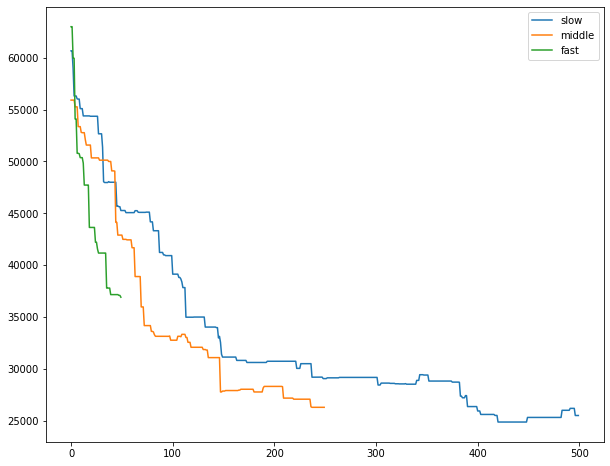

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(len(process_1)), process_1, lablel="slow")
plt.plot(np.arange(len(process_2)), process_2, label="middle")
plt.plot(np.arange(len(process_3)), process_3, )
plt.show()

## Animation

In [19]:
coors = cities_to_coordinates(df["address"])

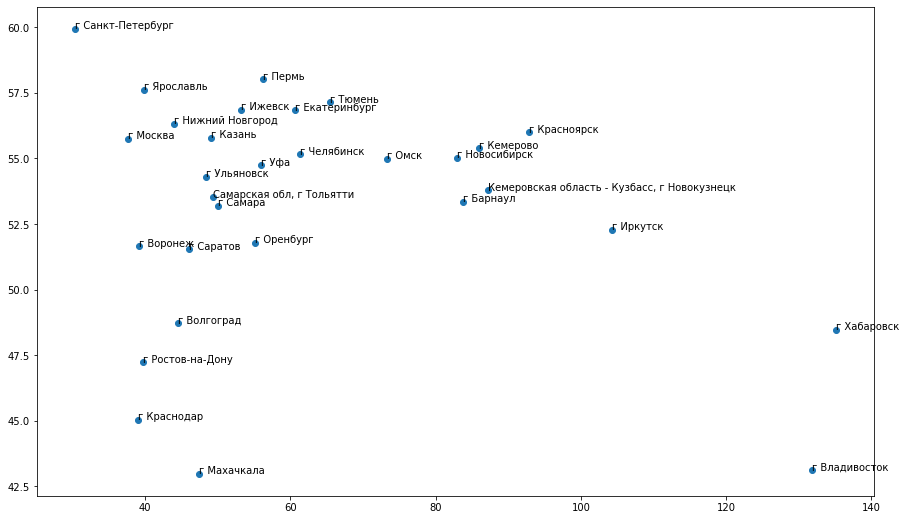

In [125]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.scatter([c[1] for c in coors], [c[0] for c in coors])
for i, city in enumerate(df["address"]):
  ax.annotate(city, xy=(coors[i][1], coors[i][0]))

line, = ax.plot([], [], lw=2)
temperature_text = ax.text(0.80, 0.95, s='', fontsize=12, transform = ax.transAxes, bbox=dict(facecolor='blue', alpha=0.5))
distance_text = ax.text(0.80, 0.90, s='', fontsize=12, transform = ax.transAxes, bbox=dict(facecolor='blue', alpha=0.5))

def init():
    line.set_data([], [])
    temperature_text.set_text('')
    distance_text.set_text('')
    return line, temperature_text, distance_text

def animate(i):
    coordinates = cities_to_coordinates(cities_1[i])
    x = [coor[1] for coor in coordinates]
    y = [coor[0] for coor in coordinates]
    distance_text.set_text('Distance: {}'.format(int(salesman_distance(cities_1[i]))))
    temperature_text.set_text("Temperature: {}".format(int(temperature_1[i])))
    line.set_data(x, y)
    return line

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(cities_1), interval=10, blit=False)

anim.save('animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])